In [33]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [34]:
base = pd.read_csv('datasets/petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[: , 1:2].values
base_valor_maximo = base.iloc[: , 2:3].values

In [35]:
base_treinamento

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [36]:
base_valor_maximo

array([[20.209999],
       [20.4     ],
       [20.620001],
       ...,
       [16.139999],
       [16.129999],
       [16.1     ]])

In [37]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo)

In [38]:
base_treinamento_normalizada

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [39]:
base_valor_maximo_normalizada

array([[0.77266112],
       [0.78187106],
       [0.79253519],
       ...,
       [0.57537562],
       [0.57489089],
       [0.57343674]])

In [40]:
X = [] #previsores
y1 = [] #preço real
y2 = [] #preço real
for i in range(90, 1242): #90 preços anteriores
    X.append(base_treinamento_normalizada[i-90: i, 0])
    y1.append(base_treinamento_normalizada[i,0])
    y2.append(base_valor_maximo_normalizada[i,0])
    
X, y1, y2 = np.array(X), np.array(y1), np.array(y2)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [41]:
X.shape

(1152, 90, 1)

In [42]:
y = np.column_stack((y1,y2))

In [43]:
y, y.shape

(array([[0.76114341, 0.76490543],
        [0.76114341, 0.7746001 ],
        [0.77470935, 0.78090155],
        ...,
        [0.57122093, 0.57537562],
        [0.57655039, 0.57489089],
        [0.57655039, 0.57343674]]),
 (1152, 2))

In [44]:
regressor = Sequential()
regressor.add(InputLayer(shape=(X.shape[1], 1)))
regressor.add(LSTM(units = 100, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=2, activation='linear'))

regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 90, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 90, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,502 (435.55 KB)

 Trainable params: 111,502 (435.55 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
regressor.compile(optimizer='rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [46]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=True)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='pesos.keras', monitor='loss', save_best_only=True, verbose=1)

In [47]:
regressor.fit(X, y, epochs=100, batch_size=32, callbacks=[es, rlr, mcp])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0725 - mean_absolute_error: 0.2043
Epoch 1: loss improved from inf to 0.03721, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0716 - mean_absolute_error: 0.2026 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0188 - mean_absolute_error: 0.1085
Epoch 2: loss improved from 0.03721 to 0.01817, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0188 - mean_absolute_error: 0.1084 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0138 - mean_absolute_error: 0.0930
Epoch 3: loss improved from 0.01817 to 0.01448, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0138 - mean_absolute_error: 0.0930 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0140 - mean_absolute_error: 0.0933
Epoch 4: loss improved from 0.01448 to 0.01300, saving model 

In [48]:
base_teste = pd.read_csv('datasets/petr4_teste.csv')
y_open = base_teste.iloc[:, 1:2].values
y_high = base_teste.iloc[:, 2:3].values

In [49]:
y_open, y_high

(array([[16.190001],
        [16.49    ],
        [16.780001],
        [16.700001],
        [16.74    ],
        [17.030001],
        [16.92    ],
        [16.879999],
        [17.040001],
        [17.32    ],
        [17.35    ],
        [17.92    ],
        [18.35    ],
        [18.309999],
        [18.26    ],
        [18.4     ],
        [18.42    ],
        [19.34    ],
        [19.620001],
        [19.67    ],
        [19.77    ],
        [19.74    ]]),
 array([[16.549999],
        [16.719999],
        [16.959999],
        [16.860001],
        [17.030001],
        [17.16    ],
        [17.049999],
        [17.299999],
        [17.41    ],
        [17.440001],
        [17.84    ],
        [18.360001],
        [18.530001],
        [18.42    ],
        [18.469999],
        [18.459999],
        [19.629999],
        [19.34    ],
        [19.98    ],
        [20.049999],
        [19.77    ],
        [19.93    ]]))

In [50]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

In [51]:
entradas

array([[0.46825012],
       [0.46000969],
       [0.46146389],
       [0.44886088],
       [0.46437227],
       [0.46970431],
       [0.4992729 ],
       [0.50315075],
       [0.5210858 ],
       [0.52496365],
       [0.51429956],
       [0.51914687],
       [0.51720795],
       [0.52157053],
       [0.52350945],
       [0.5210858 ],
       [0.52496365],
       [0.53223461],
       [0.56131847],
       [0.54920019],
       [0.55841008],
       [0.5618032 ],
       [0.5540475 ],
       [0.53805138],
       [0.54435288],
       [0.52932622],
       [0.54920019],
       [0.56374212],
       [0.56277266],
       [0.55210858],
       [0.54968492],
       [0.57489089],
       [0.57682986],
       [0.57246728],
       [0.57973825],
       [0.57634513],
       [0.57537562],
       [0.57925347],
       [0.56858943],
       [0.57779937],
       [0.58264668],
       [0.58264668],
       [0.59428022],
       [0.6063985 ],
       [0.60591372],
       [0.61560829],
       [0.61221522],
       [0.616

In [52]:
X_teste = []
for i in range(90,112):
    X_teste.append(entradas[i-90: i,0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [53]:
X_teste

array([[[0.46825012],
        [0.46000969],
        [0.46146389],
        ...,
        [0.5681047 ],
        [0.57343674],
        [0.57343674]],

       [[0.46000969],
        [0.46146389],
        [0.44886088],
        ...,
        [0.57343674],
        [0.57343674],
        [0.57779937]],

       [[0.46146389],
        [0.44886088],
        [0.46437227],
        ...,
        [0.57343674],
        [0.57779937],
        [0.59234125]],

       ...,

       [[0.54920019],
        [0.55841008],
        [0.5618032 ],
        ...,
        [0.68589433],
        [0.73048958],
        [0.74406209]],

       [[0.55841008],
        [0.5618032 ],
        [0.5540475 ],
        ...,
        [0.73048958],
        [0.74406209],
        [0.7464857 ]],

       [[0.5618032 ],
        [0.5540475 ],
        [0.53805138],
        ...,
        [0.74406209],
        [0.7464857 ],
        [0.75133301]]])

In [54]:
previsoes =  regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


In [55]:
previsoes

array([[15.745169, 15.943226],
       [15.887814, 16.08721 ],
       [16.022657, 16.223272],
       [16.159971, 16.36161 ],
       [16.298115, 16.500631],
       [16.429054, 16.632332],
       [16.554073, 16.757975],
       [16.66688 , 16.871292],
       [16.75774 , 16.962536],
       [16.82645 , 17.031448],
       [16.88676 , 17.091768],
       [16.949228, 17.15414 ],
       [17.039068, 17.243874],
       [17.182549, 17.387426],
       [17.378023, 17.58339 ],
       [17.599714, 17.80607 ],
       [17.819979, 18.027687],
       [18.014584, 18.223774],
       [18.203793, 18.414272],
       [18.412115, 18.62365 ],
       [18.643818, 18.856308],
       [18.88689 , 19.10037 ]], dtype=float32)

In [56]:
y_open, y_high

(array([[16.190001],
        [16.49    ],
        [16.780001],
        [16.700001],
        [16.74    ],
        [17.030001],
        [16.92    ],
        [16.879999],
        [17.040001],
        [17.32    ],
        [17.35    ],
        [17.92    ],
        [18.35    ],
        [18.309999],
        [18.26    ],
        [18.4     ],
        [18.42    ],
        [19.34    ],
        [19.620001],
        [19.67    ],
        [19.77    ],
        [19.74    ]]),
 array([[16.549999],
        [16.719999],
        [16.959999],
        [16.860001],
        [17.030001],
        [17.16    ],
        [17.049999],
        [17.299999],
        [17.41    ],
        [17.440001],
        [17.84    ],
        [18.360001],
        [18.530001],
        [18.42    ],
        [18.469999],
        [18.459999],
        [19.629999],
        [19.34    ],
        [19.98    ],
        [20.049999],
        [19.77    ],
        [19.93    ]]))

In [57]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_open.ravel(), previsoes[: , 0]))
print(mean_absolute_error(y_high.ravel(), previsoes[: , 1]))

0.7670708757879084
0.8352606325017756


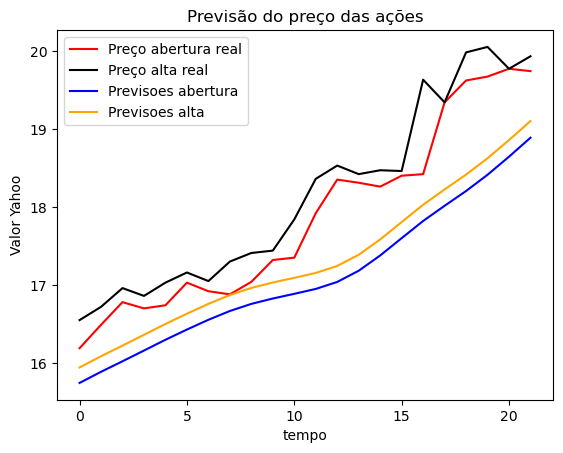

In [58]:
plt.plot(y_open, color = "red", label = "Preço abertura real")
plt.plot(y_high, color = "black", label = "Preço alta real")

plt.plot(previsoes[:, 0], color ='blue', label = 'Previsoes abertura')
plt.plot(previsoes[:, 1], color ='orange', label = 'Previsoes alta')

plt.title("Previsão do preço das ações")
plt.xlabel("tempo")
plt.ylabel("Valor Yahoo")
plt.legend();